**Parcial 2**

El objetivo de este cudernillo es el de segmentar objetos, en este caso tornillos, monedas y latas


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn.functional as F
from PIL import Image
import zipfile
import os
import random
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
with zipfile.ZipFile('drive/MyDrive/Datasets/Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, ruta):
        self.listdirimg = os.listdir(f"{ruta}/imgs")
        self.imgs = [Image.open(f"{ruta}/imgs/{i}") for i in self.listdirimg]
        self.masks = [Image.open(f"{ruta}/mask/{i[:-4]}.png") for i in self.listdirimg]

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        mask = np.array(self.masks[idx])
        # one-hot encoding
        mask_oh = (np.arange(3) == mask[...,None]).astype(np.float32)
        mask_oh = np.transpose(mask_oh, (2, 0, 1))
        return (np.transpose(np.array(self.imgs[idx])/255., (2, 0, 1))).astype(np.float32), mask, mask_oh

In [7]:
data_train = Dataset('Dataset/train')
data_val = Dataset('Dataset/valid')
data_test = Dataset('Dataset/test')

In [8]:
len(data_train),len(data_val),len(data_test)

(2328, 43, 39)

In [9]:
a,b,c = data_train[0]

In [10]:
a.shape, a.max(), a.min()

((3, 448, 448), 1.0, 0.0)

In [11]:
b.shape, b.max(), b.min()

((448, 448), 3, 0)

In [12]:
c.shape, c.max(), c.min()

((3, 448, 448), 1.0, 0.0)

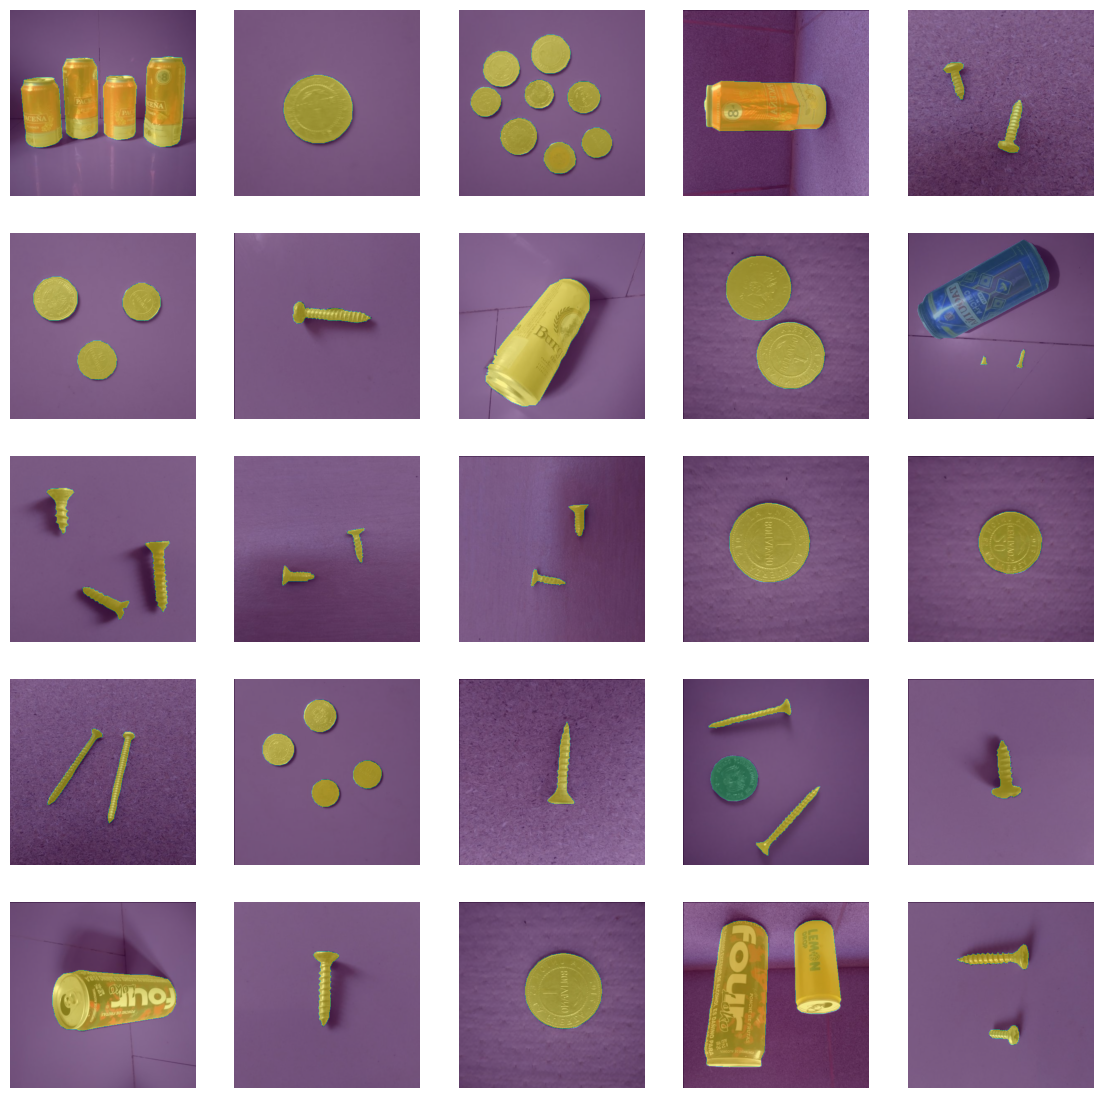

In [13]:
fig, axs = plt.subplots(5,5, figsize=(14,14))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(data_train)-1)
    img, mask, _ = data_train[ix]
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.imshow(mask, alpha=0.5)
    ax.axis('off')
plt.show()

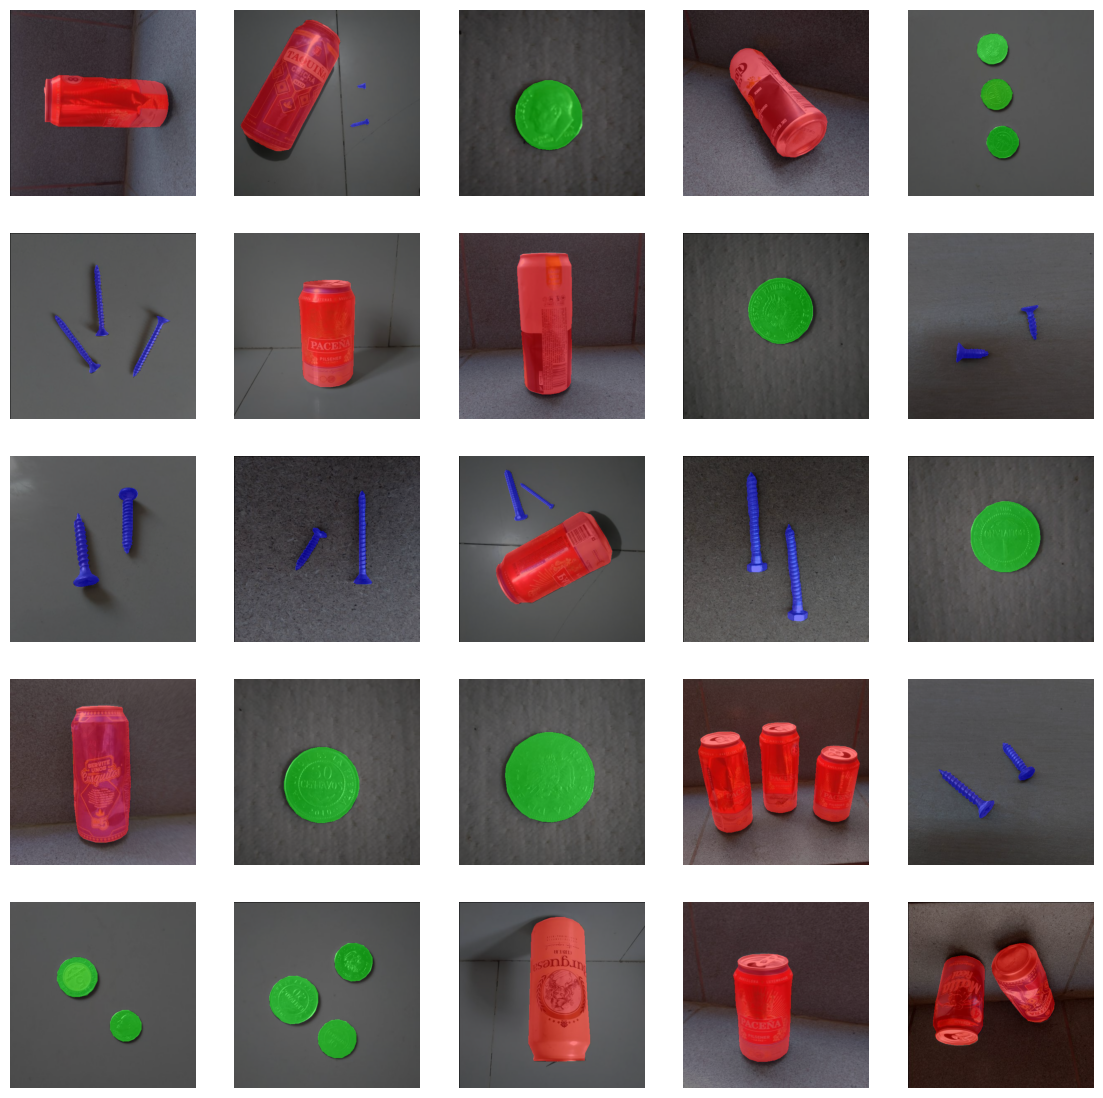

In [15]:
colors = {
    1: [1, 0, 0],
    2: [0, 1, 0],
    3: [0, 0, 1]
}
fig, axs = plt.subplots(5, 5, figsize=(14, 14))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(data_train) - 1)
        img, mask, _ = data_train[ix]
        # Crear una máscara en blanco del mismo tamaño que la imagen
        colored_mask = np.zeros_like(np.transpose(img, (1, 2, 0)))
        # Iterar sobre cada clase y asignar un color diferente
        for class_id, color in colors.items():
            # Asignar el color solo en las regiones donde la clase coincide
            colored_mask[mask == class_id] = color
        # Mostrar la imagen
        ax.imshow(np.transpose(img, (1, 2, 0)))
        # Superponer la máscara coloreada
        ax.imshow(colored_mask, alpha=0.5)
        ax.axis('off')

plt.show()

In [16]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=4, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=4, shuffle=False, pin_memory=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=4, shuffle=False, pin_memory=True)
dataloader = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

In [17]:
imgs, _, mask = next(iter(dataloader['train']))
print('Forma Xi:',imgs.shape,'|',mask.shape)

Forma Xi: torch.Size([4, 3, 448, 448]) | torch.Size([4, 3, 448, 448])


**UNet**

In [18]:
def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)

    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=1):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [20]:
model = UNet(in_ch=3)
output = model(torch.randn((4,3,448,448)))
print('Numero de parametros:',sum(p.numel() for p in model.parameters()))
print(output.shape)

Numero de parametros: 483859
torch.Size([4, 3, 448, 448])


In [21]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))
        union = (_out | _labs).float().sum((1, 2))
        iou = (intersection + SMOOTH) / (union + SMOOTH)
        ious.append(iou.mean().item())
    return np.mean(ious)

In [22]:
def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'val_loss': [], 'val_iou': [],'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
        train_loss, train_iou = [], []
        model.train()
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, _, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            ious = iou(y_hat, y)
            train_loss.append(loss.item())
            train_iou.append(ious)
            bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
        model.eval()
        with torch.no_grad():
            val_loss, val_iou = [], []
            bar = tqdm(dataloader['val'])
            for batch in bar:
                X, _, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                ious = iou(y_hat, y)
                val_loss.append(loss.item())
                val_iou.append(ious)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_iou {np.mean(val_iou):.5f}")
            test_loss, test_iou = [], []
            bar = tqdm(dataloader['test'])
            for batch in bar:
                X, _, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                ious = iou(y_hat, y)
                test_loss.append(loss.item())
                test_iou.append(ious)
                bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
        hist['loss'].append(np.mean(train_loss))
        hist['iou'].append(np.mean(train_iou))
        hist['val_loss'].append(np.mean(val_loss))
        hist['val_iou'].append(np.mean(val_iou))
        hist['test_loss'].append(np.mean(test_loss))
        hist['test_iou'].append(np.mean(test_iou))
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} val_loss {np.mean(val_loss):.5f} val_iou {np.mean(val_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}\n")
    return hist

In [24]:
model = UNet(in_ch=3)
hist = fit(model, dataloader, epochs=10)

test_loss 0.10534 test_iou 0.76292: 100%|██████████| 10/10 [00:00<00:00, 13.87it/s]


Epoch 1/10 loss 0.17677 iou 0.60720 val_loss 0.09763 val_iou 0.74412 test_loss 0.10534 test_iou 0.76292



test_loss 0.06700 test_iou 0.66316: 100%|██████████| 10/10 [00:00<00:00, 13.69it/s]


Epoch 2/10 loss 0.07757 iou 0.66284 val_loss 0.06718 val_iou 0.67650 test_loss 0.06700 test_iou 0.66316



test_loss 0.05170 test_iou 0.65849: 100%|██████████| 10/10 [00:00<00:00, 15.76it/s]


Epoch 3/10 loss 0.05706 iou 0.68364 val_loss 0.05181 val_iou 0.66019 test_loss 0.05170 test_iou 0.65849



test_loss 0.04093 test_iou 0.71426: 100%|██████████| 10/10 [00:00<00:00, 15.27it/s]


Epoch 4/10 loss 0.04539 iou 0.70638 val_loss 0.04626 val_iou 0.66972 test_loss 0.04093 test_iou 0.71426



test_loss 0.03503 test_iou 0.78149: 100%|██████████| 10/10 [00:00<00:00, 16.14it/s]


Epoch 5/10 loss 0.03857 iou 0.72282 val_loss 0.02990 val_iou 0.73707 test_loss 0.03503 test_iou 0.78149



test_loss 0.03225 test_iou 0.76232: 100%|██████████| 10/10 [00:00<00:00, 15.74it/s]


Epoch 6/10 loss 0.03043 iou 0.74424 val_loss 0.02768 val_iou 0.74693 test_loss 0.03225 test_iou 0.76232



test_loss 0.02742 test_iou 0.77702: 100%|██████████| 10/10 [00:00<00:00, 15.89it/s]


Epoch 7/10 loss 0.02648 iou 0.77163 val_loss 0.03154 val_iou 0.74556 test_loss 0.02742 test_iou 0.77702



test_loss 0.02952 test_iou 0.77317: 100%|██████████| 10/10 [00:00<00:00, 16.17it/s]


Epoch 8/10 loss 0.02104 iou 0.80439 val_loss 0.02965 val_iou 0.81284 test_loss 0.02952 test_iou 0.77317



test_loss 0.01718 test_iou 0.87636: 100%|██████████| 10/10 [00:00<00:00, 15.66it/s]


Epoch 9/10 loss 0.02213 iou 0.81328 val_loss 0.01802 val_iou 0.85680 test_loss 0.01718 test_iou 0.87636



test_loss 0.02279 test_iou 0.80829: 100%|██████████| 10/10 [00:00<00:00, 15.89it/s]

Epoch 10/10 loss 0.01742 iou 0.83735 val_loss 0.02204 val_iou 0.79957 test_loss 0.02279 test_iou 0.80829



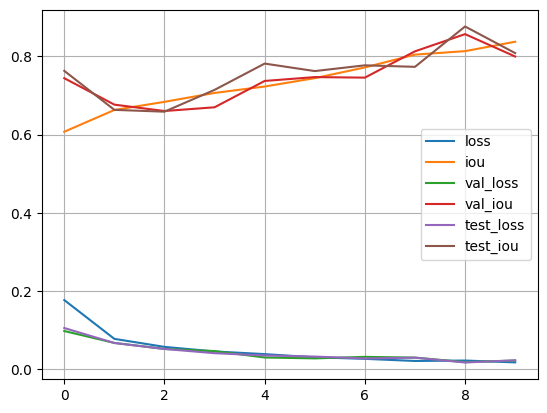

In [25]:
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

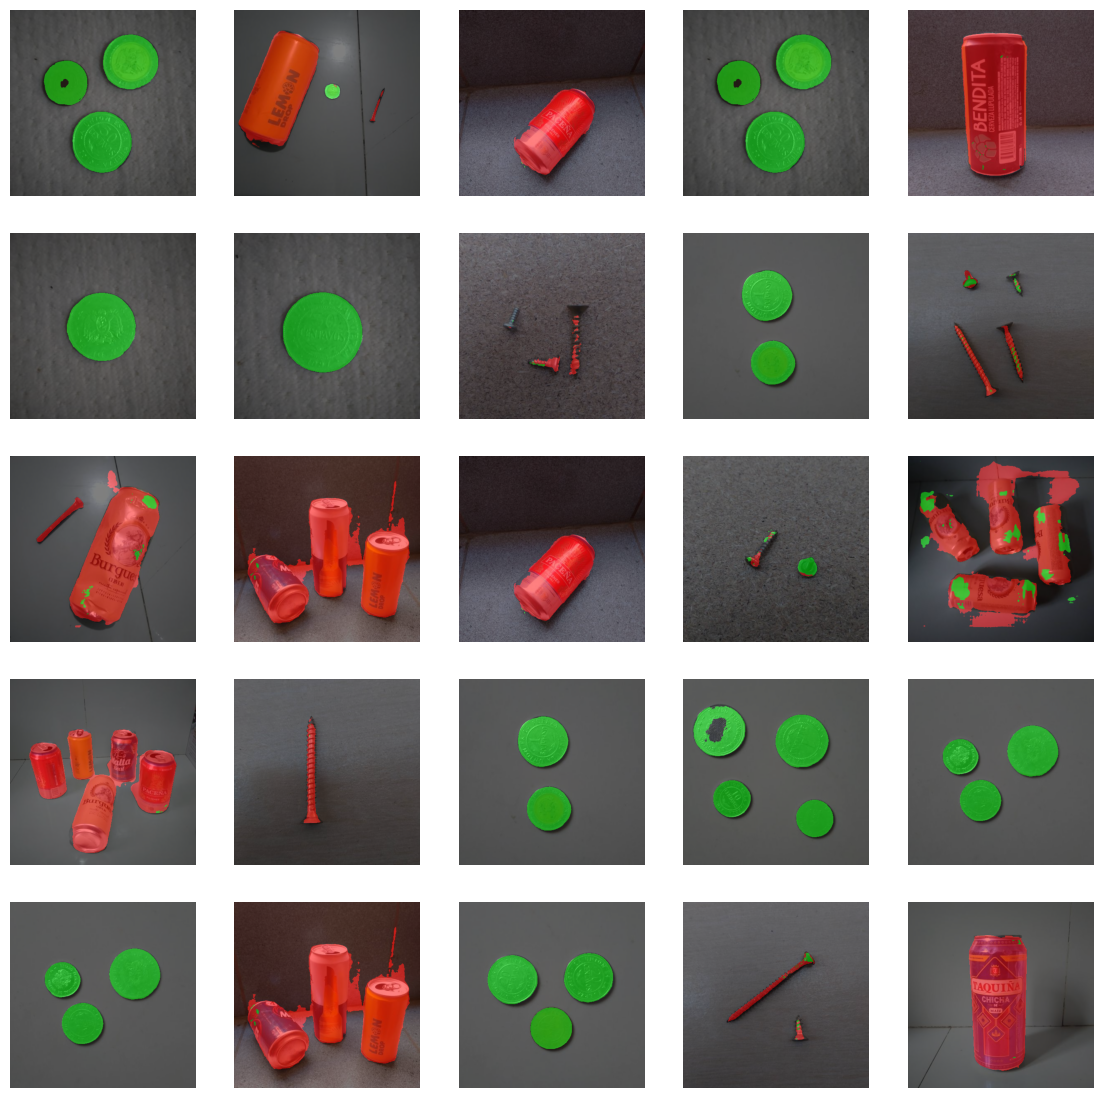

In [26]:
model.eval()
fig, axs = plt.subplots(5, 5, figsize=(14, 14))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(data_test) - 1)
        img, mask, _ = data_test[ix]
        with torch.no_grad():
            output = model(torch.from_numpy(img).unsqueeze(0).to(device))[0]
            pred_mask = torch.argmax(output, axis=0)
        # Crear una máscara en blanco del mismo tamaño que la imagen
        colored_mask = np.zeros_like(np.transpose(img, (1, 2, 0)))
        pred_mask = pred_mask.cpu().numpy()
        # Iterar sobre cada clase y asignar un color diferente
        for class_id, color in colors.items():
            # Asignar el color solo en las regiones donde la clase coincide
            colored_mask[pred_mask == class_id] = color
        # Mostrar la imagen
        ax.imshow(np.transpose(img, (1, 2, 0)))
        # Superponer la máscara coloreada
        ax.imshow(colored_mask, alpha=0.5)
        ax.axis('off')

plt.show()

torch.Size([3, 448, 448])
torch.Size([448, 448])
(3, 448, 448)
torch.Size([3, 448, 448])


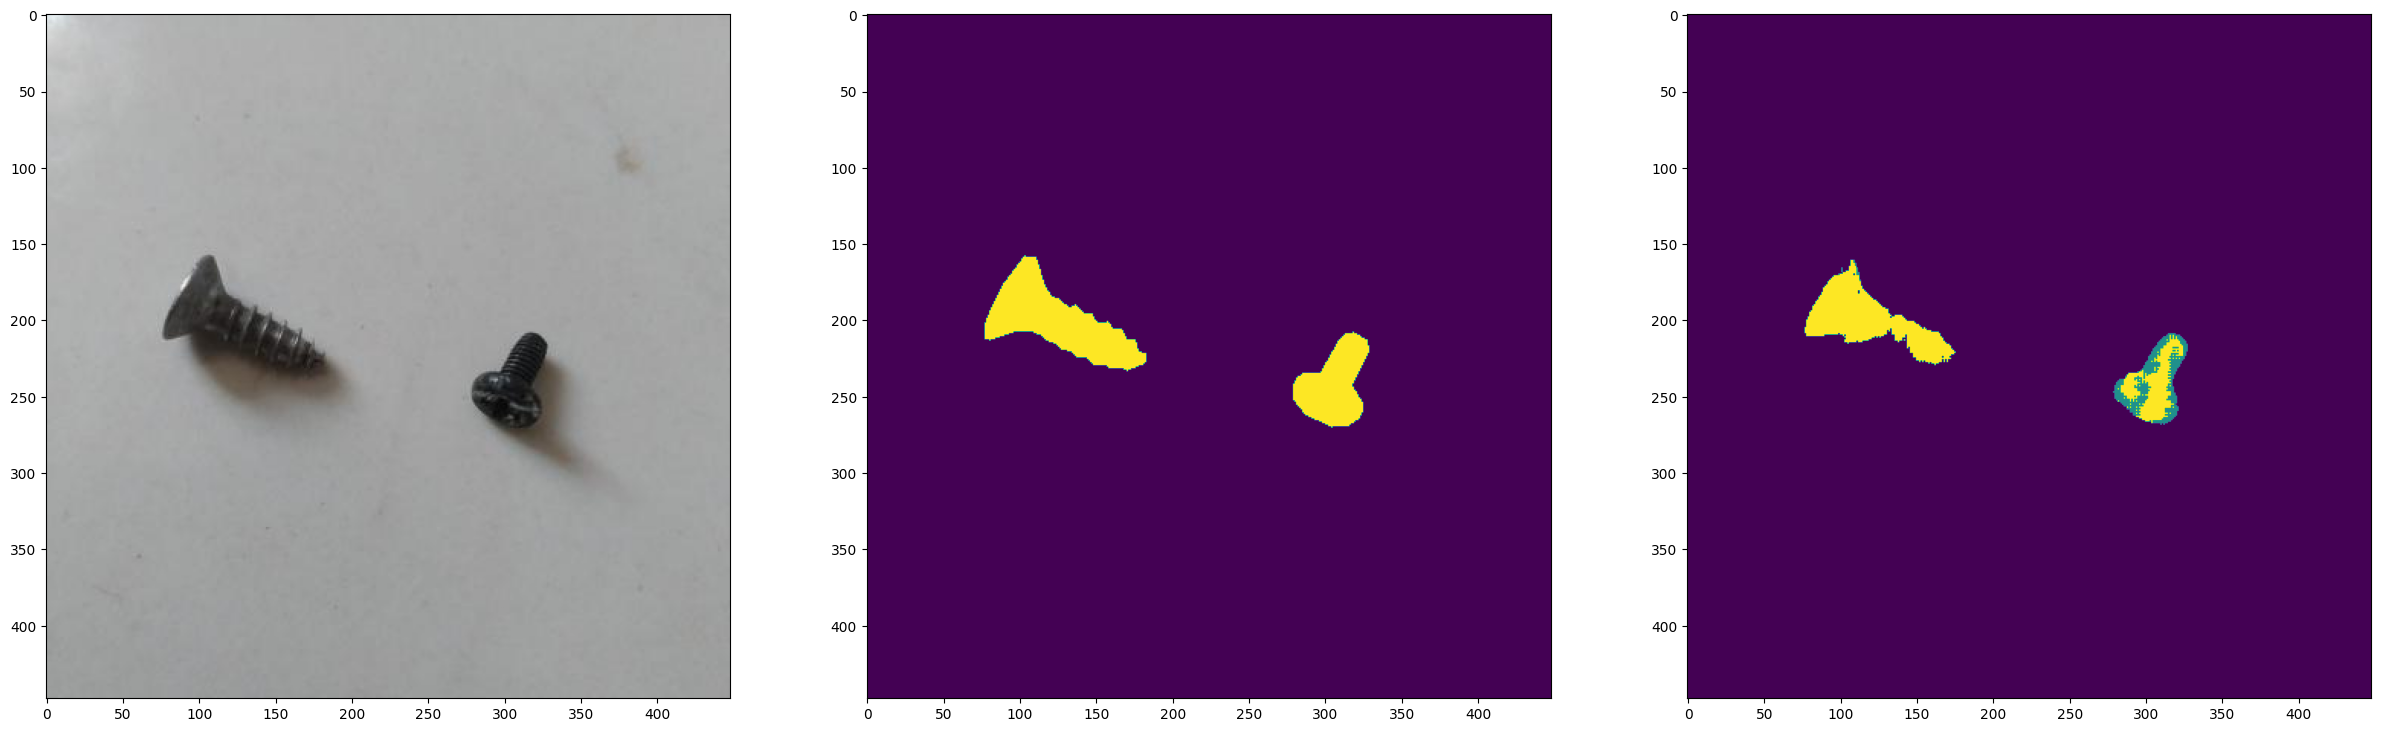

In [27]:
model.eval()
with torch.no_grad():
    ix = random.randint(0, len(data_val)-1)
    img, mask, mask_oh = data_val[ix]
    output = model(torch.from_numpy(img).unsqueeze(0).to(device))[0]
    print(output.shape)
    pred_mask = torch.argmax(output, axis=0)
    print(pred_mask.shape)
print(img.shape)
print(output.shape)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(torch.from_numpy(img).permute(1,2,0))
ax2.imshow(mask)
ax3.imshow(pred_mask.cpu().numpy())
plt.show()

**Transfer Learning**

In [ ]:
class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=1):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True)
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = torch.tensor(x.clone())
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

In [ ]:
model = UNetResnet(in_ch=3)
print((torch.randn((4,3,448,448)).dtype))
output = model(torch.randn((4,3,448,448)))
print('Numero de parametros:',sum(p.numel() for p in model.parameters()))
print(output.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.float32


<ipython-input-12-79df0860ce6f>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


Numero de parametros: 14756907
torch.Size([4, 3, 448, 448])
